In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from langdetect import detect

In [2]:
df = pd.read_csv('merged.csv' , sep='\t', encoding='utf-8', index_col=0)
df

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
0,unsexed green tree python + 60cm vivtek,1000.0,Python Snake,3 years,Mixed,~3years old gtp biak x sorong\r\n\r\nTypical g...,Patryk M.,Aberdeen,Individual,sale,reptiles
1,Leopard gecko (f),80.0,Gecko,1 year,Female,Selling this leopard gecko I've had the joy of...,Dana I.,Aberdeen,Individual,sale,reptiles
2,rexy,100.0,Iguana,4 years,Male,rexy needs a new home ASP\r\n sadly I don't no...,Gillian W.,Aberdeen,Individual,sale,reptiles
3,Panther Chameleon and full set up,550.0,Chameleon,9 months,Male,Blue is a 6 month old Nosey Mitsio chameleon. ...,Craig H.,Aberdeen,Individual,sale,reptiles
4,Hand reared white Indian ringnecks,300.0,Parakeets,9 weeks,Mixed,I have 2 stunning white Indian ringnecks. 1 ma...,Dave T.,Aberdeen,Individual,sale,birds
...,...,...,...,...,...,...,...,...,...,...,...
48778,canarys for sale all colour plus new colours,40.0,Canaries,7 weeks,Mixed,there are all mixed cocks and hens new volour ...,Robert n.,Knottingley,Breeder,sale,birds
48779,TAME & TALKING HARNESS TRAINED BLUE & GOLD MACAW,2150.0,Macaws,4 years,Male,Rainbow is a beautiful example of a blue and g...,The Bradford Birdman,Bradford,Licensed Breeder,sale,birds
48780,Hand reared indian ringnecks babys,350.0,Parrots,1 year,Male,Hand reared cuddly silly tame little babys for...,Waqar A.,Bradford,Breeder,sale,birds
48781,One yellow one orange canary.,60.0,Canaries,2 years,Mixed,I’m reluctantly listing my canaries (peach and...,Amylia R.,Barnsley,Individual,sale,birds


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48783 entries, 0 to 48782
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            48783 non-null  object 
 1   price            48783 non-null  float64
 2   species          48783 non-null  object 
 3   age              48783 non-null  object 
 4   gender           48783 non-null  object 
 5   description      48783 non-null  object 
 6   seller_name      48783 non-null  object 
 7   seller_location  48783 non-null  object 
 8   seller_type      48783 non-null  object 
 9   listing_type     48783 non-null  object 
 10  pet_type         48783 non-null  object 
dtypes: float64(1), object(10)
memory usage: 4.5+ MB


In [4]:
df.nunique()

Title              37519
price                394
species              438
age                  101
gender               139
description        44800
seller_name        20520
seller_location     1083
seller_type            5
listing_type           3
pet_type              11
dtype: int64

In [5]:
df['gender'].value_counts()

unknown                11934
Mixed                   6199
Male                    3719
1 male                  2857
Female                  2796
                       ...  
03 male / 03 female        1
03 male / 01 female        1
03 male / 02 female        1
7 male / 8 female          1
05 male / 1 female         1
Name: gender, Length: 139, dtype: int64

We should combine these 'x number of male and y number of female' as mixed litters and remove the numbers from the others

In [6]:
df['gender'] = df['gender'].apply(lambda x: 'Mixed' if (' male' in x and 'female' in x) else x)
df['gender'] = df['gender'].apply(lambda x: 'Female' if (' female' in x) else x)
df['gender'] = df['gender'].apply(lambda x: 'Male' if (' male' in x) else x)
df['gender'].value_counts()

Mixed       20614
unknown     11934
Male         8851
Female       7085
Mare          139
Gelding       117
Stallion       43
Name: gender, dtype: int64

This is satisfactory enough. Mare, Gelding and Stallion are horses.

In [7]:
df.nunique()

Title              37519
price                394
species              438
age                  101
gender                 7
description        44800
seller_name        20520
seller_location     1083
seller_type            5
listing_type           3
pet_type              11
dtype: int64

In [8]:
df['seller_type'].value_counts()

Individual          29109
Breeder             16573
Licensed Breeder     2388
Rescue/Charity        707
Company                 6
Name: seller_type, dtype: int64

In [19]:
df['seller_location'].value_counts().tail(100)

Appleby In Westmorland    1
Гул                       1
Солфорд                   1
St Austell                1
Busveal                   1
                         ..
Wylam                     1
Chester Le Street         1
Filey                     1
Ulceby                    1
Ilkley                    1
Name: seller_location, Length: 100, dtype: int64

Funny to have location data in foreign language. Probably should take a look at the posting.

In [20]:
df.loc[df['seller_location'] == 'Солфорд']

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
41536,sold,900.0,Siamese,4 months,Mixed,We have available 1 Blue Point Siamese boy and...,Viktorija K.,Солфорд,Breeder,sale,cats


In [26]:
df['age'].value_counts().tail(20)

2001              3
16 years          3
2000              3
Due in 6 weeks    3
2003 years        2
Due in 6 days     2
18 years          2
2004 years        2
20 years          2
2002 years        2
1998              1
2000 years        1
24 years          1
Due in 7 weeks    1
42 years          1
1999              1
66 years          1
2019 years        1
23 years          1
17 years          1
Name: age, dtype: int64

Some of these are very funny. probably it's the year of birth. Longer living animals tends to have their year of birth recorded as age, horses in particular

In [27]:
df['pet_type'].value_counts()

dogs             23151
cats             11490
rabbits           4400
rodents           2321
birds             2068
reptiles          1955
poultry           1528
fish              1031
invertebrates      366
horses             299
livestock          174
Name: pet_type, dtype: int64

In [44]:
df.loc[df['pet_type'] == 'horses']

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
287,tradition gypsy cob gelding,1200.0,Other Breed,2022,Gelding,shamus is 2 years old wormed passport microchi...,nicola r.,Truro,Breeder,sale,horses
288,Silversmith Burlesque Queen,2700.0,Miniature,2015,Mare,Silversmith Burlesque Queen This beautiful AMH...,Z A.,Redruth,Individual,sale,horses
549,Hart braking sale,3000.0,Welsh Section A,2006,Mare,Sadly I’ve come to the decision to let our gor...,Pugsforlove P.,Sturminster Newton,Individual,sale,horses
550,3 year old registered welsh section C Mare,2000.0,Welsh Section C,2019,Mare,Walena Lucky Charm \r\n\r\nQuality 3 year old ...,Emily G.,Salisbury,Individual,sale,horses
551,"9 month old mixed breed colt, slightly spotted",650.0,Welsh Section A,2021,Stallion,"Ronnie is halter broken, will be groomed but n...",Tilly c.,Wincanton,Individual,sale,horses
...,...,...,...,...,...,...,...,...,...,...,...
44424,2 jenny donkeys very friendly,900.0,Other Breed,2010,Mare,"Age 12 years, always been together\nBoth passp...",Mark G.,Wrexham,Individual,sale,horses
44425,Super alrounder,0.0,Welsh Section D,2009,Mare,"\n\n13 year old, section D, 14.2hh\n\nM&M has ...",Sharon P.,Holywell,Individual,sale,horses
46928,1 year old to make 15.2+,0.0,Welsh Section D,2021,Gelding,Not something I was planning on writing any ti...,Leah G.,Scunthorpe,Individual,sale,horses
46929,29” palomino 3 year old shetland colt,700.0,Shetland pony,2019,Stallion,\nFor sale is Harry the 3 year old palomino co...,TJ V.,Doncaster,Individual,sale,horses


very funny to see 0 at pricing. probably need to contact to ask for price

In [ ]:
df['price'].value_counts()

In [40]:
df.sort_values(by=['price'], ascending=False).head(20)

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
24578,For TEMPORARY Foster/Temporary Adoption,11111111.0,British Shorthair,3 years,Male,I'm looking for a loving TEMPORARY foster home...,Amy W.,Newark,Individual,adoption,cats
1530,Working Cocker spaniel dog pup,9999999.0,Cocker Spaniel,12 weeks,Male,One Liver Working cocker spaniel dog pup for s...,Joanne b.,Lymington,Licensed Breeder,sale,dogs
9625,2 male Chihuahua puppies for sale,9999999.0,Chihuahua,9 weeks,Male,Here we have two beautiful stunning chihuahua ...,Danielle E.,Kidderminster,Individual,sale,dogs
43000,OUTSTANDING 53 CHAMPS IN 5G BL,3333333.0,Cocker Spaniel,1 week,unknown,THE BEST IN BREED are here 🤗\n\nSIRE is KC - s...,Sarah sherman s.,Stoke-on-Trent,Individual,sale,dogs
28647,OUTSTANDING 53 CHAMPS IN 5G BL,3333333.0,Cocker Spaniel,1 week,unknown,THE BEST IN BREED are here 🤗\r\n\r\nSIRE is KC...,Sarah sherman s.,Stoke-on-Trent,Individual,sale,dogs
200,Franco,1234567.0,Golden Retriever,3 years,unknown,Lovely natured golden retriever.\r\nGreat with...,Colin M.,Inverurie,Breeder,stud,dogs
1144,Top Basset for Stud,1111111.0,Basset Hound,1 year,unknown,Looking to stud out my big boy\r\nprobably onl...,Darren P.,Romsey,Individual,stud,dogs
17105,❌••L4 FLUFFY CARRIERS••❌Coco girl❌,987654.0,French Bulldog,14 weeks,Mixed,\n\n❤️Beautiful pups from our blue girl❤️\nRom...,JACQUELINE I.,Hailsham,Individual,sale,dogs
2821,Stolen coco,888888.0,Bengal,2 years,unknown,Good morning we haven't seen coco since 15th F...,Nic I.,Stonehouse,Individual,sale,cats
23758,ragdoll cross,150350.0,Ragdoll,10 weeks,Mixed,"5 stunning ragdoll cross kittens, 3 girls 2 bo...",Layna L.,Runcorn,Breeder,sale,cats


some of the pricing makes no sense, owner probably want potential buyer to contact them. We should drop these. these outliers make price histogram unworkable.

In [48]:
df.loc[df['price'] == 0.0]

,Title,price,species,age,gender,description,seller_name,seller_location,seller_type,listing_type,pet_type
32,African Cichlids bundle,0.0,Cichlids,1 year,unknown,"hi, I have got around 19 African cichlids look...",Margaret B,Peterculter,Breeder,sale,fish
33,Guppies for sale,0.0,Other/Mixed Breed,12 weeks,unknown,2 1/2 months old mixed guppies for sale: make...,Anil G.,Aberdeen,Individual,sale,fish
234,2 Beautiful Mini Lops,0.0,Mini Lop,1 year,Mixed,We are looking to rehome our 2 gorgeous bunnie...,Abigail W.,Helston,Individual,adoption,rabbits
296,HORSFIELD TORTOISES - 2 years old.,0.0,Tortoise,2 years,Female,Adoption only!\r\nPoppy & Penny are two beauti...,Caley A.,Truro,Individual,adoption,reptiles
441,Full list baby ball python CB21,0.0,Python Snake,1 year,Mixed,"Passione breeder based in Southampton, here to...",Eden Garden Reptiles,Southampton,Breeder,sale,reptiles
...,...,...,...,...,...,...,...,...,...,...,...
46728,chocolate seal point female mini lop,0.0,Mini Lop,1 year,Female,daisy ❤️ chocolate seal point pure bred mini l...,Hip Hop B,Leeds,Breeder,sale,rabbits
46848,BABY BLUE HOLICER RABBITS,0.0,Mixed Breed,6 months,Male,Iv had to put these babies under mixed breed a...,Mini F Stud,Leeds,Breeder,sale,rabbits
46887,RARE BABY HOLICER BABIES - READ DESCRIPTION,0.0,Continental Giant,14 weeks,Mixed,- I have put them into the continental giant c...,Mini F Stud,Leeds,Breeder,sale,rabbits
46890,Rabbits for sale,0.0,English Lop,15 weeks,Mixed,"We have 5 beautiful rabbits for sale,they are ...",Kian R.,Wakefield,Individual,sale,rabbits


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


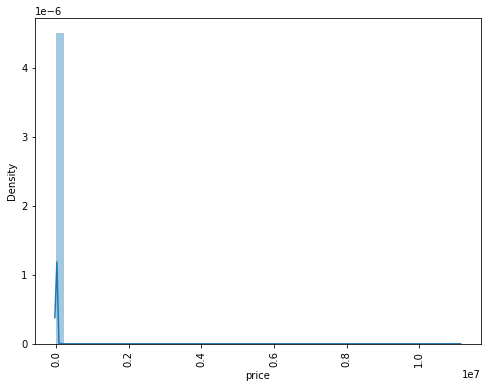

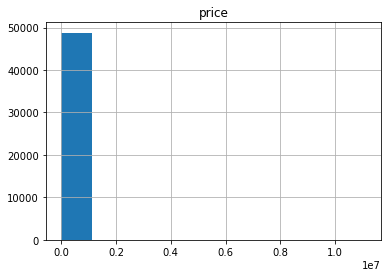

In [39]:
hist = df.hist(bins=10)

KeyError: False

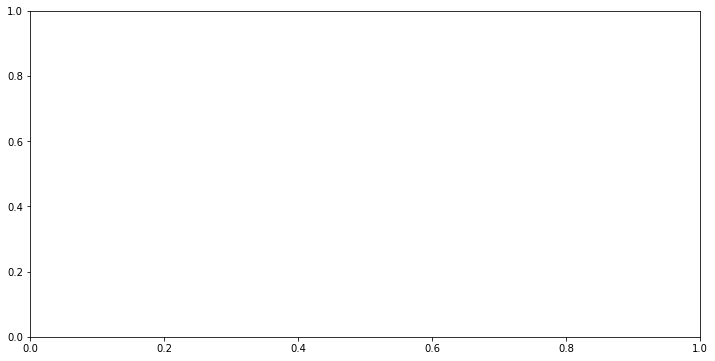

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.distplot(df['pet_type'=='dogs'], bins=20, ax=ax,  label='benign')
sns.distplot(df['pet_type'=='cats'], bins=20, ax=ax,  label='malign')
ax.legend()
plt.show()